# 3. Interpolation Schemes and Modifier Types

**Pedagogical context.** This notebook covers how systematic
uncertainties enter a HistFactory model, corresponding to Cowan's
Lecture 13 and the modifier system documented in Cranmer et al.
(CERN-OPEN-2012-016). The interpolation schemes are the mathematical
backbone; the modifier types are the physicist-facing interface.

A modifier transforms the nominal yield of a sample as a function of
one or more nuisance parameters. The transformation is specified by an
interpolation scheme that maps the nuisance parameter $\alpha$ (where
$\alpha = 0$ is nominal, $\pm 1$ is the $\pm 1\sigma$ variation) to
a scale factor or shifted histogram. The choice of scheme controls the
smoothness, positivity, and extrapolation behaviour.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 12, "figure.facecolor": "white"})

from histimator import Histogram, Sample, Channel, Model
from histimator.interpolation import InterpolationCode, interpolate
from histimator.likelihood import fit

## 3.1 The four interpolation codes

Histimator implements the four standard HistFactory interpolation codes.
All take the same inputs: a nuisance parameter value $\alpha$, a nominal
value, and the down/up variations at $\alpha = \mp 1$. They differ in
their mathematical form.

**Code 0 (piecewise linear)** is the simplest: it interpolates linearly
between the nominal and the up or down variation depending on the sign
of $\alpha$. It has a kink at $\alpha = 0$ when the up and down
variations are asymmetric, which makes the likelihood non-differentiable
and can cause fitting difficulties.

**Code 1 (piecewise exponential)** resolves both problems. It
interpolates exponentially, so the result is always positive and the
function is smooth everywhere. This is the default in Histimator.

**Code 2 (quadratic interpolation, linear extrapolation)** uses a
parabola for $|\alpha| \leq 1$ and switches to linear extrapolation
outside. It is smooth at $\alpha = 0$ but can go negative for large
excursions.

**Code 3 (polynomial interpolation, exponential extrapolation)** matches
the exponential form and its first two derivatives at $|\alpha| = 1$
using a degree-6 polynomial, giving C2-smooth transitions.

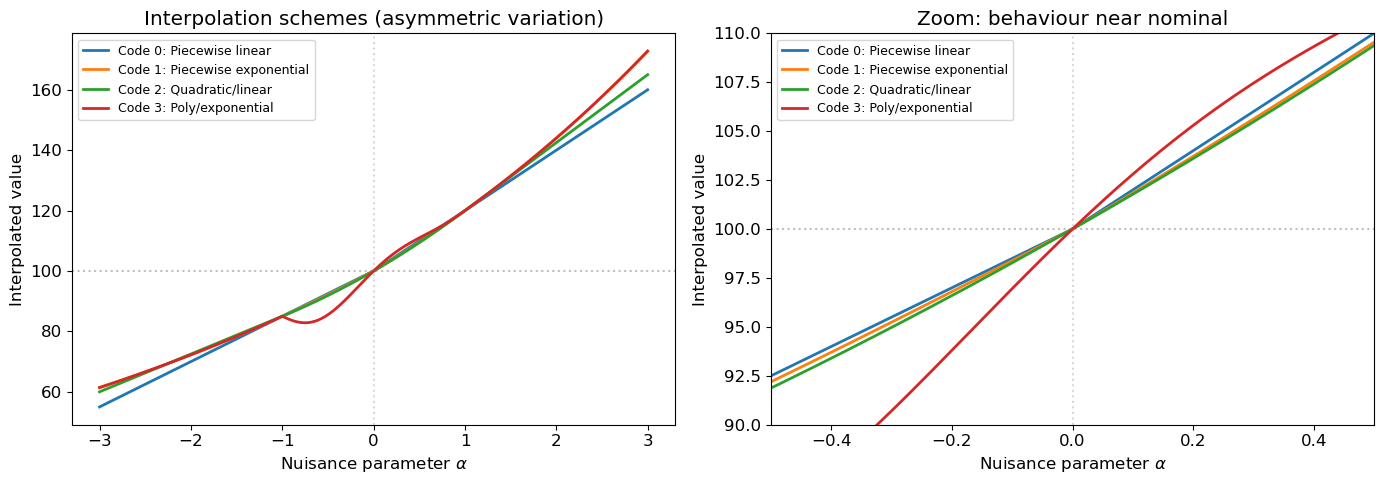

In [2]:
# Compare all four codes with an asymmetric variation
alpha_range = np.linspace(-3, 3, 500)
nominal = 100.0
down = 85.0    # -15% at alpha = -1
up = 120.0     # +20% at alpha = +1

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

schemes = [
    (InterpolationCode.PIECEWISE_LINEAR, "Code 0: Piecewise linear", "C0"),
    (InterpolationCode.PIECEWISE_EXPONENTIAL, "Code 1: Piecewise exponential", "C1"),
    (InterpolationCode.QUADRATIC_LINEAR, "Code 2: Quadratic/linear", "C2"),
    (InterpolationCode.POLY_EXPONENTIAL, "Code 3: Poly/exponential", "C3"),
]

for code_enum, label, color in schemes:
    values = [float(interpolate(a, nominal, down, up, code_enum)) for a in alpha_range]
    axes[0].plot(alpha_range, values, label=label, color=color, linewidth=2)

axes[0].axhline(nominal, color="gray", ls=":", alpha=0.5)
axes[0].axvline(0, color="gray", ls=":", alpha=0.3)
axes[0].set_xlabel(r"Nuisance parameter $\alpha$")
axes[0].set_ylabel("Interpolated value")
axes[0].set_title("Interpolation schemes (asymmetric variation)")
axes[0].legend(fontsize=9)

# Zoom into the kink region
for code_enum, label, color in schemes:
    values = [float(interpolate(a, nominal, down, up, code_enum)) for a in alpha_range]
    axes[1].plot(alpha_range, values, label=label, color=color, linewidth=2)

axes[1].set_xlim(-0.5, 0.5)
axes[1].set_ylim(90, 110)
axes[1].axhline(nominal, color="gray", ls=":", alpha=0.5)
axes[1].axvline(0, color="gray", ls=":", alpha=0.3)
axes[1].set_xlabel(r"Nuisance parameter $\alpha$")
axes[1].set_ylabel("Interpolated value")
axes[1].set_title("Zoom: behaviour near nominal")
axes[1].legend(fontsize=9)

plt.tight_layout()
plt.show()

The zoom on the right panel reveals the kink in Code 0 at
$\alpha = 0$. Codes 1 through 3 are smooth through the origin.
The exponential schemes (1 and 3) guarantee positivity even at
large $|\alpha|$, while Code 2 can produce negative values if
extrapolated far enough. For most LHC analyses, Code 1 is the
right default because it is smooth, positive, and computationally
cheap.

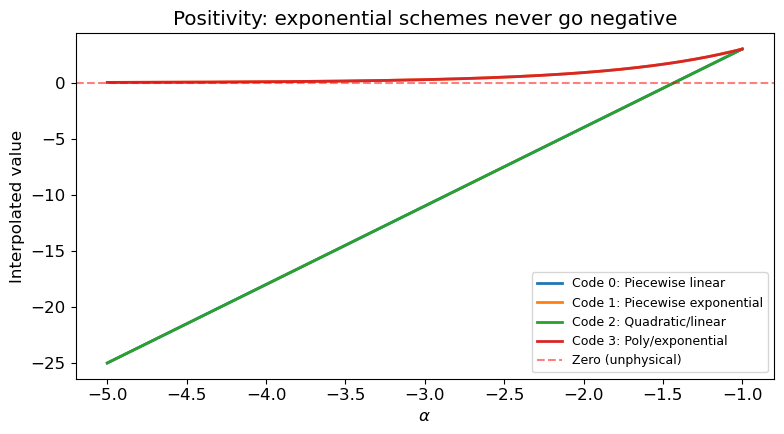

In [3]:
# Demonstrate positivity: push alpha very negative with a small nominal
alpha_neg = np.linspace(-5, -1, 200)
nom_small = 10.0
down_small = 3.0
up_small = 17.0

fig, ax = plt.subplots(figsize=(8, 4.5))
for code_enum, label, color in schemes:
    vals = [float(interpolate(a, nom_small, down_small, up_small, code_enum))
            for a in alpha_neg]
    ax.plot(alpha_neg, vals, label=label, color=color, linewidth=2)

ax.axhline(0, color="red", ls="--", alpha=0.5, label="Zero (unphysical)")
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel("Interpolated value")
ax.set_title("Positivity: exponential schemes never go negative")
ax.legend(fontsize=9)
plt.tight_layout()
plt.show()

## 3.2 NormFactor: free normalisation

The simplest modifier is a multiplicative scale factor with no
constraint. When named "mu" and attached to the signal sample, it
serves as the parameter of interest. It can also model a free
background normalisation that is determined entirely by the fit.

In [4]:
edges = np.array([0.0, 1.0, 2.0, 3.0, 4.0, 5.0])
sig = Sample("signal", Histogram([2, 8, 12, 8, 2], edges))
sig.add_normfactor("mu", nominal=1.0, bounds=(0.0, 10.0))

for mu_val in [0.0, 0.5, 1.0, 2.0, 5.0]:
    yields = sig.expected({"mu": mu_val})
    print(f"  mu = {mu_val:.1f}: total = {yields.sum():.1f}, per-bin = {yields}")

  mu = 0.0: total = 0.0, per-bin = [0. 0. 0. 0. 0.]
  mu = 0.5: total = 16.0, per-bin = [1. 4. 6. 4. 1.]
  mu = 1.0: total = 32.0, per-bin = [ 2.  8. 12.  8.  2.]
  mu = 2.0: total = 64.0, per-bin = [ 4. 16. 24. 16.  4.]
  mu = 5.0: total = 160.0, per-bin = [10. 40. 60. 40. 10.]


## 3.3 NormSys: overall normalisation systematic

A NormSys scales the entire sample yield by a factor that depends on
$\alpha$. For a 10% uncertainty, `lo=0.9` and `hi=1.1` mean the sample
yield is multiplied by 0.9 at $\alpha = -1$ and 1.1 at $\alpha = +1$.
The constraint term in the likelihood is a standard Gaussian: the NLL
picks up a term $\alpha^2 / 2$ that penalises departures from nominal.

This modifier is used for uncertainties that affect the overall rate of a
process without changing its shape: luminosity, trigger efficiency,
inclusive cross-section.

In [5]:
bkg = Sample("background", Histogram([40, 50, 45, 35, 30], edges))
bkg.add_normsys("bkg_xsec", lo=0.9, hi=1.1)

for alpha in [-2, -1, 0, 1, 2]:
    yields = bkg.expected({"bkg_xsec": float(alpha)})
    ratio = yields / bkg.histogram.values
    print(f"  alpha = {alpha:+d}: scale = {ratio[0]:.4f}, total = {yields.sum():.1f}")

  alpha = -2: scale = 0.8100, total = 162.0
  alpha = -1: scale = 0.9000, total = 180.0
  alpha = +0: scale = 1.0000, total = 200.0
  alpha = +1: scale = 1.1000, total = 220.0
  alpha = +2: scale = 1.2100, total = 242.0


## 3.4 HistoSys: shape systematic

A HistoSys provides different histogram templates for the up and down
variations. The interpolation operates bin by bin, so the shape of the
prediction changes with $\alpha$. This is the standard treatment for
uncertainties that alter the distribution shape: jet energy scale,
$b$-tagging efficiency variations, PDF uncertainties.

The key difference from NormSys is that each bin can scale by a
different amount. This makes HistoSys more general but also more
data-hungry, since it requires full histogram templates for both
variations.

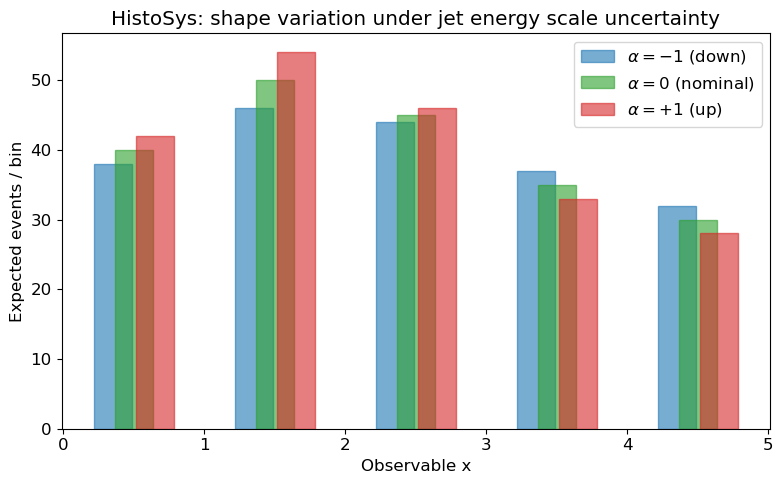

In [6]:
bkg_nom = Histogram([40, 50, 45, 35, 30], edges)
bkg_down = Histogram([38, 46, 44, 37, 32], edges)
bkg_up   = Histogram([42, 54, 46, 33, 28], edges)

bkg_shape = Sample("background", bkg_nom)
bkg_shape.add_histosys("jes", lo_hist=bkg_down, hi_hist=bkg_up)

fig, ax = plt.subplots(figsize=(8, 5))
centres = bkg_nom.centres
w = 0.15

for alpha, color, label in [
    (-1, "C0", r"$\alpha = -1$ (down)"),
    (0, "C2", r"$\alpha = 0$ (nominal)"),
    (1, "C3", r"$\alpha = +1$ (up)"),
]:
    yields = bkg_shape.expected({"jes": float(alpha)})
    offset = alpha * w
    ax.bar(centres + offset, yields, width=w*1.8, alpha=0.6,
           color=color, edgecolor=color, label=label)

ax.set_xlabel("Observable x")
ax.set_ylabel("Expected events / bin")
ax.set_title("HistoSys: shape variation under jet energy scale uncertainty")
ax.legend()
plt.tight_layout()
plt.show()

## 3.5 StatError: MC statistical uncertainty (Barlow-Beeston)

When background templates come from simulated Monte Carlo events, each
bin has a statistical uncertainty from limited MC statistics. The
Barlow-Beeston approach introduces one constrained parameter per bin,
$\gamma_i$, that multiplies the yield in bin $i$. Each $\gamma_i$ is
constrained by a Gaussian at $N(1, \delta_i)$, where $\delta_i$ is
the relative MC uncertainty in that bin.

This is especially important for bins with few MC events, where the
template itself is poorly known.

In [7]:
bkg_mc = Sample("background", Histogram([40, 50, 10, 5, 2], edges))
# Relative MC uncertainty: 5% in high-stats bins, 30% in low-stats bins
rel_unc = [0.05, 0.05, 0.15, 0.25, 0.35]
bkg_mc.add_staterror("mc_stat", rel_unc)

print(f"Parameters: {[p.name for p in bkg_mc.parameters]}")
print(f"Number of gamma parameters: {len(bkg_mc.parameters)}")

# Show effect of varying one gamma
params = {p.name: 1.0 for p in bkg_mc.parameters}
print(f"\nNominal yields:  {bkg_mc.expected(params)}")
params["gamma_mc_stat_bin4"] = 1.5  # 50% up in last bin
print(f"gamma_bin4=1.5:  {bkg_mc.expected(params)}")

Parameters: ['gamma_mc_stat_bin0', 'gamma_mc_stat_bin1', 'gamma_mc_stat_bin2', 'gamma_mc_stat_bin3', 'gamma_mc_stat_bin4']
Number of gamma parameters: 5

Nominal yields:  [40. 50. 10.  5.  2.]
gamma_bin4=1.5:  [40. 50. 10.  5.  3.]


## 3.6 ShapeSys: per-bin Poisson-constrained uncertainty

ShapeSys is similar to StatError but uses a Poisson constraint instead
of a Gaussian. This is appropriate when the uncertainty derives from a
counting measurement in an auxiliary dataset (for example, a data-driven
background estimate from a sideband). The Poisson auxiliary data encodes
the effective number of events that determined the rate in each bin.

In [8]:
bkg_dd = Sample("data_driven_bkg", Histogram([20, 30, 25, 15, 10], edges))
bkg_dd.add_shapesys("dd_stat", [0.15, 0.10, 0.12, 0.20, 0.25])

print(f"Parameters: {[p.name for p in bkg_dd.parameters]}")
params = {p.name: 1.0 for p in bkg_dd.parameters}
print(f"Nominal: {bkg_dd.expected(params)}")

Parameters: ['gamma_dd_stat_bin0', 'gamma_dd_stat_bin1', 'gamma_dd_stat_bin2', 'gamma_dd_stat_bin3', 'gamma_dd_stat_bin4']
Nominal: [20. 30. 25. 15. 10.]


## 3.7 ShapeFactor: unconstrained per-bin normalisation

A ShapeFactor introduces a free parameter per bin with no constraint at
all. The shape of the sample is determined entirely by the fit to data.
This is used for backgrounds whose shape cannot be predicted from
simulation and must be extracted from control regions.

In [9]:
bkg_free = Sample("multijet", Histogram([10, 10, 10, 10, 10], edges))
bkg_free.add_shapefactor("mj_shape")

print(f"Parameters: {[p.name for p in bkg_free.parameters]}")
params = {p.name: 1.0 for p in bkg_free.parameters}
params["sf_mj_shape_bin2"] = 3.0  # triple the yield in bin 2
print(f"With sf_bin2=3.0: {bkg_free.expected(params)}")

Parameters: ['sf_mj_shape_bin0', 'sf_mj_shape_bin1', 'sf_mj_shape_bin2', 'sf_mj_shape_bin3', 'sf_mj_shape_bin4']
With sf_bin2=3.0: [10. 10. 30. 10. 10.]


## 3.8 LumiSys: luminosity systematic

A LumiSys is a Gaussian-constrained overall scale factor, like NormSys,
but parameterised differently. Instead of specifying up/down scale
factors, you specify the relative uncertainty directly. The parameter
is centred at 1.0 (not 0.0), and the constraint is
$\mathcal{N}(1, \sigma_L)$.

This modifier should be applied to all MC-based samples (signal and
simulated backgrounds) but not to data-driven backgrounds.

In [10]:
sig_lumi = Sample("signal", Histogram([2, 8, 12, 8, 2], edges))
sig_lumi.add_normfactor("mu", nominal=1.0, bounds=(0.0, 10.0))
sig_lumi.add_lumisys("lumi", uncertainty=0.017)  # 1.7% luminosity uncertainty

for lumi_val in [0.95, 0.983, 1.0, 1.017, 1.05]:
    yields = sig_lumi.expected({"mu": 1.0, "lumi": lumi_val})
    print(f"  lumi = {lumi_val:.3f}: total = {yields.sum():.2f}")

  lumi = 0.950: total = 30.40
  lumi = 0.983: total = 31.46
  lumi = 1.000: total = 32.00
  lumi = 1.017: total = 32.54
  lumi = 1.050: total = 33.60


## 3.9 Combining modifiers in a realistic model

A real sample typically carries several modifiers simultaneously. The
modifiers are applied sequentially: normfactors multiply, interpolated
systematics multiply or shift, and gamma factors multiply. The order
follows the attachment order, though for multiplicative modifiers the
result is commutative.

In [11]:
# Realistic signal sample with multiple modifiers
sig_full = Sample("signal", Histogram([2, 8, 12, 8, 2], edges))
sig_full.add_normfactor("mu", nominal=1.0, bounds=(0.0, 10.0))
sig_full.add_normsys("sig_xsec", lo=0.95, hi=1.05)
sig_full.add_lumisys("lumi", uncertainty=0.017)
sig_full.add_staterror("sig_mc", [0.3, 0.1, 0.08, 0.1, 0.3])

print(f"Total modifiers: {len(sig_full.modifiers)}")
print(f"Total parameters: {len(sig_full.parameters)}")

# Nominal prediction
nom = {p.name: p.value for p in sig_full.parameters}
print(f"Nominal yields: {sig_full.expected(nom)}")

Total modifiers: 4
Total parameters: 8
Nominal yields: [ 2.  8. 12.  8.  2.]


## Exercises

**Exercise 3.1.** For a symmetric 10% NormSys (`lo=0.9, hi=1.1`),
compare the interpolated scale factor at $\alpha = 0.5$ for all four
interpolation codes. Which codes give identical results for symmetric
variations, and why?

**Exercise 3.2.** Create a background sample with a HistoSys whose
up variation increases the yield in bins 1 and 2 while decreasing it in
bins 4 and 5 (a "migration" systematic). Plot the expected yields at
$\alpha = -1, 0, +1$ and confirm that the total yield is approximately
conserved. Explain why conservation is only approximate under Code 1.

**Exercise 3.3.** Build a model with a single 10-bin background sample
that has StatError modifiers with relative uncertainties ranging from
2% to 50% across bins. Fit the model to Poisson pseudo-data generated
from the nominal prediction. Examine the fitted $\gamma_i$ values and
confirm that the high-uncertainty bins show larger pulls from 1.0.

## References

K. Cranmer, G. Lewis, L. Moneta, A. Shibata, W. Verkerke.
"HistFactory: A tool for creating statistical models for use with
RooFit and RooStats." CERN-OPEN-2012-016, Section 4: Interpolation
and Modifiers.

R.J. Barlow, C. Beeston. "Fitting using finite Monte Carlo samples."
Computer Physics Communications 77 (1993) 219-228.